### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Copie este notebook y **modifique el nombre de archivo** agregando los apellidos de ambos miembros. Por ejemplo si los miembros del grupo son Pablo Huijse y Ana Nuñez el nombre sería: `info147_tarea2_huijse_nuñez.ipynb`
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña Puede agregar a su compañero en la pestaña *Settings/Manage access*
1. Sean leales y honestos, no copie los resultados de otros grupos, el único afectado es usted
1. Se evaluará el último commit antes de la fecha y hora de entrega

# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







## Introducción

En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos para comprobar o refutar los hallazgos de *D. Treisman*

## Datos

Para esta tarea se les provee de un conjunto de datos indexado por país con los siguientes atributos
- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(30)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0
Cuba,0,8.590968,16.239990,8
Haiti,0,6.521256,16.081251,58
Dominican Republic,0,8.491694,16.092798,58
Jamaica,0,8.542905,14.798313,45


## Modelo

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> Note que el número de billonarios es una variable entera y no-negativa. Un modelo de regresión con verosimilitud Gaussiano no es apropiado

Se pide entonces que use una [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), definimos entonces la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 
- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

Considerando esto, se pide que

> Ajuste $\theta$ mediante la maximización de la verosimilitud

En primer lugar se pide que
1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es grande?
1. Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema
1. Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
# Importamos la librería
import matplotlib as mpl
display(mpl.__version__)
import matplotlib.pyplot as plt
from scipy.special import factorial as fact
import pandas as pd
import scipy.optimize
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import train_test_split

'3.1.3'

#### 1.  Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro  𝜆 , ¿Qué ocurre cuando  𝜆  es grande?

La regresión de Poisson es una distribucion de probabilidad discreta. Y representa el número de ocurrencias, lambda corresponde a la tasa esperada de ocuurrencias. X es el vector de atributos del país (Población, PIB y años en GATT en nuestro caso).

La distribución de Poisson es un modelo apropiado si se cumplen las siguientes condiciones:

* k es el número de veces que un evento ocurre en un intervalo y puede tomar valores enteros mayores que -1.
* Los eventos ocurren de forma independiente.
* La tasa promedio en la que los eventos ocurren es independiente de cualquier ocurrencia. Es además constante.
* Dos eventos no pueden ocurrir al mismo instante.

**λ = 1** Evento que en promedio ocurre una vez por intervalo: k0 = k1 = 0.37 

A medida que lambda incrementa, la probabilidad de eventos en un intervalo se asemeja más y más a una distribución normal, donde el número de eventos k  con mayor probabilidad es igual a lambda (al valor entero más cercano).


In [4]:
def poisonxd(lmbd, y):
    return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
    #return (lmbd**y/fact(y)) * np.exp(-lmbd)

<IPython.core.display.Javascript object>


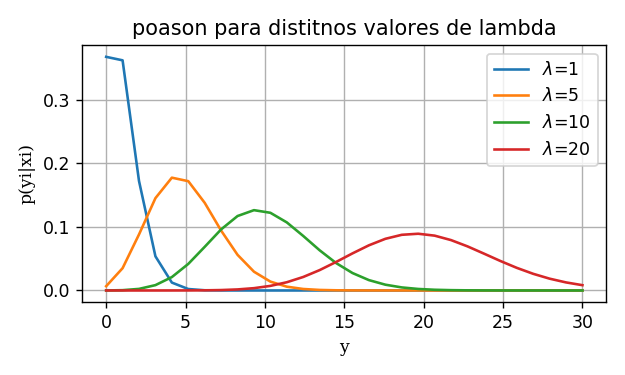

In [5]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True, facecolor='w')
# Tipos de linea: -, --, -., :, none
# Tipos de markers: .,o,x,d,s,1,2,3,4
y = np.linspace(start=0, stop=30, num=30)


#incorporar un intSlider para los valores de lambda?
for i in [1, 5, 10, 20]:
    values = [poisonxd(i, val) for val in y]
    plt.plot(y, values, label=f'$\lambda$={i}')
    
    
ax.set_ylabel('p(yi|xi)', fontsize=10, fontname='serif', color="black")
ax.set_xlabel('y', fontsize=10, fontname='serif', color="black")
ax.set_title('poason para distitnos valores de lambda')    
ax.grid()
ax.legend()
plt.show()

###### Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema

$$
\begin{align}
\mathcal{L}(\theta) &= \prod_{i=1}^N P(y_i|\theta) \nonumber \\
\mathcal{L}(\theta) &= \prod_{i=1}^N \frac{\lambda_i^{y_i}}{y_i!} e^\left ({-\lambda_i} \right) \nonumber \\
\end{align}
$$
aplicando log se tiene
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log (\frac{\lambda_i^{y_i}}{y_i!})-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N \log (\lambda_i^{y_i}) - \log (y_i!)-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N {y_i} \log (\lambda_i) - \log (y_i!)-\lambda_i \nonumber \\
\end{align}
$$

###### Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud


derivada con respecto a  $\theta_0$
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_0}=\sum_{i=1}^N ({y_i} - \lambda_i)
\end{align}
$$

derivada con respecto a  $\theta_j$ con $\mathcal{j}$>0
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_j}=\sum_{i=1}^N (({y_i} - \lambda_i) \sum_{i=1}^M {x_{ij}})
\end{align}
$$


## Implementación

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`
1. Encuentre el vector de parámetros óptimo usando `scipy.optimize.minimize`, justifique su decisión para el método y argumentos a usar
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y para el pseudo coeficiente de correlación


In [6]:
import statsmodels.api as sm

df['const'] = 1

reg1 = ['const','logpibpc', 'logpob', 'gatt']

poisson_reg = sm.Poisson(df['nbillonarios'], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:           nbillonarios   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 Aug 2020   Pseudo R-squ.:                  0.8574
Time:                        15:11:20   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
logpibpc       1.0839      0.

In [7]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(30)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0
Cuba,0,8.590968,16.239990,8
Haiti,0,6.521256,16.081251,58
Dominican Republic,0,8.491694,16.092798,58
Jamaica,0,8.542905,14.798313,45


In [8]:
def poisonxd(lmbd, Y):
    return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)
    #return (lmbd**y/fact(y)) * np.exp(-lmbd)


In [9]:
def modelo(theta, X, Y):
    lmbd = np.exp(theta[0] + np.sum(theta[1:]*X, axis=1))
    return poisonxd(lmbd, Y), lmbd

    #f = theta[0] + np.sum(theta[1:]*X, axis=1)     
    #return sigmoide(f), f

In [10]:
def neglogverosimilitud(theta, *args):
    X,Y = args
    P, lmbd = modelo(theta, X,Y)
    #-np.sum(-np.logaddexp(0, -f) - (1-y)*f, axis=0)
    #return -np.sum((Y * np.log(lmbd + 1e-10) - lmbd - fact(Y)), axis=0)
    return -np.sum((Y * np.log(lmbd + 1e-10) - lmbd), axis=0)
    

In [191]:
def grad_neglogverosimilitud(theta, *args):
    X, Y = args
    N = len(Y)
    s, f = modelo(theta, X, Y)  
    sumatoriaX = np.sum(X, axis=1)
    #para theta sub 0
    e = (Y - f)
    #para theta sub j, j > 0
    r = e * sumatoriaX
    #es lo mismo para j = 1, 2, 3
    GT0 = np.ones(shape=(N, theta.shape[0] - 1)) * r[:, np.newaxis]
    #unir sol para j == 0 y j > 0
    sol = np.concatenate((e[:, np.newaxis], GT0), axis=1)
    return -np.sum(sol, axis=0)

In [190]:
#display(X)
#np.sum(X, axis=1)
#display(y)
#display(best_theta)
display(grad_neglogverosimilitud(best_theta, *(X, y)))
#display(best_theta.shape)

90.318867

array([  -578.06696673, -53608.0342699 , -53608.0342699 , -53608.0342699 ])

In [78]:
#df = pd.read_csv('billonarios.csv', index_col='pais')
#display(df.head(5))

#df = df.drop('United States')
#y = df['nbillonarios'].values

#x=df.drop(['nbillonarios'], axis=1)
#X=x.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)

display(X_train[:5])

#thetacool = [ -29.0495,  1.0839 , 1.1714,  0.0060]


array([[10.743365 , 17.319439 ,  0.       ],
       [ 7.117458 , 13.604913 , 14.       ],
       [ 5.904355 , 16.505932 , 58.       ],
       [ 7.0818877, 16.790787 , 60.       ],
       [ 8.870089 , 15.829421 , 12.       ]])

In [225]:
# Usaremos un callback para guardar el mejor modelo de validación
def eval_model(theta):  
    global best_theta, best_logl
    logltrain = neglogverosimilitud(theta, *(X_train, y_train))
    logltest = neglogverosimilitud(theta, *(X_test, y_test))
    print("Train: %0.4f, Test: %0.4f" %(logltrain, logltest))   
    if logltest < best_logl: # Guardar el mejor modelo de test
        best_theta = theta
        best_logl = logltest
        
        
# Valor inicial de theta
#theta = [ -29.0495,  1.0839 , 1.1714,  0.0060]
#theta = [ 0.05457863,  0.30377906,  0.09626512, -0.00523775]
theta = 0.2*np.random.randn(1+X.shape[1])
display(theta)
# Mejor valor de theta
best_theta = np.zeros(1+X.shape[1])
# Mejor valor de la verosimilitud
best_logl = np.inf
res = scipy.optimize.minimize(fun=neglogverosimilitud, x0=theta, 
                              method='Nelder-Mead', jac=grad_neglogverosimilitud, 
                              args=(X_train, y_train),
                              callback=eval_model, tol=1e-1)



#method=’CG’
#Nelder-Mead
#Powell
#BFGS

#display(best_theta)
print(res.message)
#display(best_logl)
display(best_theta)


array([-0.51595704, -0.08132417,  0.16462973, -0.07815849])

Train: 168.9774, Test: 2008.6996
Train: 168.9774, Test: 2008.6996
Train: 168.9774, Test: 2008.6996
Train: 162.1902, Test: 1448.8926
Train: 137.8452, Test: 1039.8917
Train: 137.8452, Test: 1039.8917
Train: 121.1435, Test: 243.6399
Train: 121.1435, Test: 243.6399
Train: 114.3618, Test: -250.4106
Train: 114.3618, Test: -250.4106
Train: 97.2862, Test: 399.6442
Train: 97.2862, Test: 399.6442
Train: 96.9415, Test: 222.7009
Train: 70.5411, Test: -1004.2878
Train: 70.5411, Test: -1004.2878
Train: 70.5411, Test: -1004.2878
Train: 68.8599, Test: -758.1051
Train: 58.8927, Test: -937.0045
Train: 58.8927, Test: -937.0045
Train: 58.8927, Test: -937.0045
Train: 50.1772, Test: -648.7688
Train: 45.7046, Test: -838.5283
Train: 45.7046, Test: -838.5283
Train: 45.7046, Test: -838.5283
Train: 45.7046, Test: -838.5283
Train: 45.2906, Test: -949.8187
Train: 45.2906, Test: -949.8187
Train: 45.2906, Test: -949.8187
Train: 45.2906, Test: -949.8187
Train: 45.2906, Test: -949.8187
Train: 45.1171, Test: -761.9688


<ipython-input-8-495204172950>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)
<ipython-input-8-495204172950>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)


array([-2.94987060e+01,  1.47120757e+00,  9.90147624e-01, -1.23429624e-02])

In [229]:
y = df['nbillonarios'].values

##bestTheta = [ -29.0495,  1.0839 , 1.1714,  0.0060]
bestTheta0 = best_theta[0]
#bestTheta0 = -2.96210167e+01 
lmbd0 = np.ones(shape=(len(y), 1)) * abs(bestTheta0)
#display(lmbd0)
logBestTheta0 = np.sum((y * np.log(lmbd0) - lmbd0))

#display(logBestTheta0)
#display(neglogverosimilitud(bestTheta, *(X, y)))

R2 = (abs(logBestTheta0) - abs(neglogverosimilitud(best_theta, *(X, y)))) / abs(logBestTheta0)
display(R2)

<ipython-input-8-495204172950>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)
<ipython-input-8-495204172950>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)


0.9922346506620999

In [230]:
p, lmdPredict = modelo(best_theta, X, y)
#display(lmdPredict)



<ipython-input-8-495204172950>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)
<ipython-input-8-495204172950>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)


array([1.43968295e+02, 3.16841114e+01, 1.29342633e-01, 4.76079125e-02,
       1.86204319e-01, 4.15461641e-01, 9.11654739e-03, 1.67410179e-01,
       5.88220612e-02, 2.31984342e-01, 3.67862598e-02, 3.40416159e-03,
       6.59389109e-03, 8.63510312e-03, 4.93912144e-03, 1.36604073e-02,
       5.52732151e-03, 6.65186692e+00, 7.34437349e-03, 1.77514289e-01,
       5.35685393e-02, 1.07383744e-01, 1.68279211e-02, 2.17951776e-01,
       1.02457868e-01, 1.30314459e+00, 2.67538985e+00, 6.15113520e-03,
       1.46780644e-02, 3.58691529e-01, 6.87097641e-01, 7.45583520e+00,
       5.85081351e-02, 8.91925071e-02, 9.02099400e-01, 2.46773810e+00,
       1.50297430e-01, 5.41770197e-02, 2.68755627e+01, 3.94723388e+00,
       2.01785420e+01, 5.27435497e+00, 8.53802037e-01, 2.81814109e+01,
       2.98963702e-01, 1.61919808e-01, 6.94075692e+00, 1.40563106e+01,
       9.05970724e-02, 2.44916974e+00, 3.75870405e+01, 4.31760895e+00,
       4.63635600e+00, 1.27213602e+00, 2.00239648e+00, 8.82247557e-01,
      

In [231]:
df.head(10)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0
Cuba,0,8.590968,16.239990,8
Haiti,0,6.521256,16.081251,58
Dominican Republic,0,8.491694,16.092798,58
Jamaica,0,8.542905,14.798313,45


In [232]:
df['predicted'] = lmdPredict

In [243]:
paises = df.index.values[:15].astype(str)
display(paises)

array(['United States', 'Japan', 'Germany', 'Canada', 'France',
       'United Kingdom', 'China', 'Italy', 'Netherlands', 'Spain',
       'Russian Federation', 'Australia', 'Sweden', 'Korea, Rep.',
       'Norway'], dtype='<U18')

,nbillonarios,logpibpc,logpob,gatt,predicted
pais,,,,,
United States,469,10.786021,19.532846,60,143.968295
Japan,24,10.544774,18.665226,53,46.618504
Germany,59,10.729205,18.223572,57,37.587040
Canada,25,10.743365,17.319439,0,31.684111
France,14,10.722429,17.980175,60,28.181411
United Kingdom,35,10.717536,17.939528,60,26.875563
China,42,8.143926,21.004417,7,24.380228
Italy,13,10.612207,17.890106,58,22.466099
Netherlands,5,10.943957,16.615568,4,20.178542


<IPython.core.display.Javascript object>


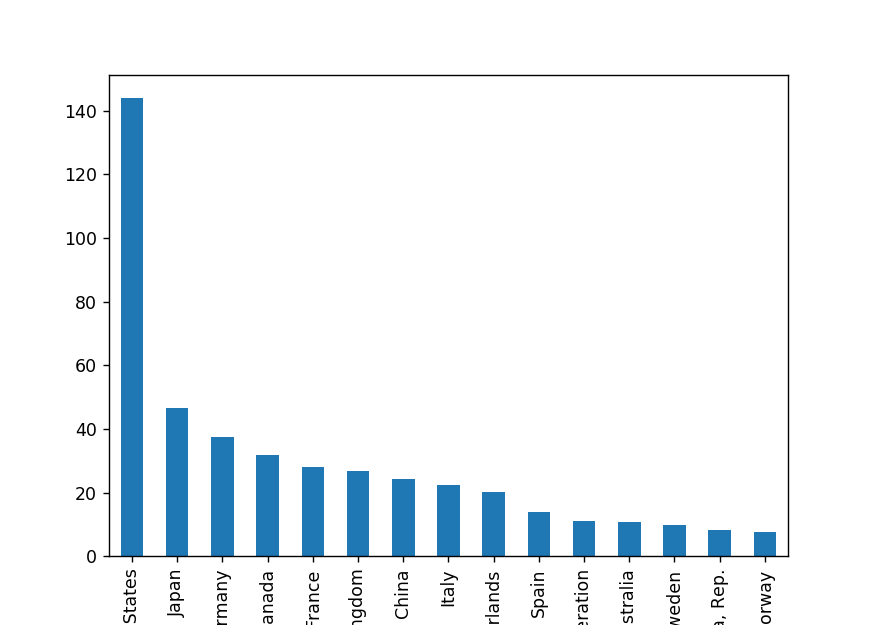

In [246]:
df.sort_values('predicted', ascending=False, inplace=True)
#paises = df.index.values
display(df.head(10))

#display(results['pais'][:15])

#display(results['pais'][:15])


#figb, bx = plt.subplots(figsize=(8, 6), tight_layout=True, facecolor='w')
df[:15].plot(y = 'predicted', kind='bar', figsize=(7,5), legend=False, use_index = True)



In [498]:
results.loc['Russian Federation']

nbillonarios                    87
logpibpc                   9.36681
logpob                      18.771
gatt                            37
predicted                  20.6115
pais            Russian Federation
Name: Russian Federation, dtype: object

## Resultados

1. Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles paises tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 